# XGBoost Model (With Market Cap Restriction)
本模型採用 XGBoostClassifier, 並考慮市值>200億的股票

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

from module import *
import xgboost

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']

## Load Price Data

In [4]:
price = load_price_data()
price_oos = load_price_data(path='./data/price_daily_oos.csv')
#price_0813 =load_price_data(path='./data/price_0813.csv')

/Users/stuartlu/Documents/國泰人壽/ML 選股/module.py:28: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  price = pd.read_csv(path, encoding='cp950')


In [5]:
price = combine_df(price, price_oos)
price = calculate_daily_return(price)
price = remove_special_stocks(price)
price

Open      High       Low     Close  Volume  \
證券代碼     年月日                                                          
1101 台泥  2015-01-05   20.3688   20.3688   20.0872   20.1810    2842   
         2015-01-06   19.9464   19.9933   19.7586   19.8290    7654   
         2015-01-07   19.8290   19.9698   19.6413   19.7586    8719   
         2015-01-08   19.8290   20.0168   19.7586   19.8290    8697   
         2015-01-09   19.8525   19.9933   19.6178   19.6178   10494   
...                       ...       ...       ...       ...     ...   
9958 世紀鋼 2024-08-07  180.0000  194.5000  178.5000  194.5000    6104   
         2024-08-08  189.0000  198.0000  185.0000  188.0000    8152   
         2024-08-09  194.5000  198.5000  191.5000  192.5000    6130   
         2024-08-12  194.0000  210.5000  192.0000  200.5000   10251   
         2024-08-13  204.0000  205.0000  197.5000  204.0000    5167   

                     QuoteVolume  MarketCap  YSTD Close  TMR Close  \
證券代碼     年月日                                                         
1101 台泥  2015-01-05       122244     158764         NaN    19.8290   
         2015-01-06       324150     155994     20.1810    19.7586   
         2015-01-07       368171     155441     19.8290    19.8290   
         2015-01-08       369425     155994     19.7586    19.6178   
         2015-01-09       441333     154333     19.8290    19.1250   
...                          ...        ...         ...        ...   
9958 世紀鋼 2024-08-07      1151229      49966    177.0000   188.0000   
         2024-08-08      1560724      48297    194.5000   192.5000   
         2024-08-09      1191760      49453    188.0000   200.5000   
         2024-08-12      2088179      51508    192.5000   204.0000   
         2024-08-13      1047438      52407    200.5000        NaN   

                     Daily Return  
證券代碼     年月日                       
1101 台泥  2015-01-05     -0.017596  
         2015-01-06     -0.003557  
         2015-01-07      0.003557  
         2015-01-08     -0.010708  
         2015-01-09     -0.025441  
...                           ...  
9958 世紀鋼 2024-08-07     -0.033990  
         2024-08-08      0.023654  
         2024-08-09      0.040718  
         2024-08-12      0.017306  
         2024-08-13           NaN  

[2156377 rows x 10 columns]

In [6]:
price = price[price.index.get_level_values(1) >= '2015-04-22']
price

Open      High       Low     Close  Volume  \
證券代碼     年月日                                                          
1101 台泥  2015-04-22   20.5330   20.5565   20.3688   20.5330    6269   
         2015-04-23   20.5565   21.2370   20.5330   21.1666   16591   
         2015-04-24   21.2605   21.3074   21.0727   21.0962   14753   
         2015-04-27   21.0962   21.1431   20.9789   20.9789    9098   
         2015-04-28   20.9789   21.0727   20.4626   20.6269   14593   
...                       ...       ...       ...       ...     ...   
9958 世紀鋼 2024-08-07  180.0000  194.5000  178.5000  194.5000    6104   
         2024-08-08  189.0000  198.0000  185.0000  188.0000    8152   
         2024-08-09  194.5000  198.5000  191.5000  192.5000    6130   
         2024-08-12  194.0000  210.5000  192.0000  200.5000   10251   
         2024-08-13  204.0000  205.0000  197.5000  204.0000    5167   

                     QuoteVolume  MarketCap  YSTD Close  TMR Close  \
證券代碼     年月日                                                         
1101 台泥  2015-04-22       274095     161533     20.5330    21.1666   
         2015-04-23       740166     166517     20.5330    21.0962   
         2015-04-24       664674     165963     21.1666    20.9789   
         2015-04-27       408215     165040     21.0962    20.6269   
         2015-04-28       645387     162271     20.9789    20.4626   
...                          ...        ...         ...        ...   
9958 世紀鋼 2024-08-07      1151229      49966    177.0000   188.0000   
         2024-08-08      1560724      48297    194.5000   192.5000   
         2024-08-09      1191760      49453    188.0000   200.5000   
         2024-08-12      2088179      51508    192.5000   204.0000   
         2024-08-13      1047438      52407    200.5000        NaN   

                     Daily Return  
證券代碼     年月日                       
1101 台泥  2015-04-22      0.030391  
         2015-04-23     -0.003332  
         2015-04-24     -0.005576  
         2015-04-27     -0.016921  
         2015-04-28     -0.007997  
...                           ...  
9958 世紀鋼 2024-08-07     -0.033990  
         2024-08-08      0.023654  
         2024-08-09      0.040718  
         2024-08-12      0.017306  
         2024-08-13           NaN  

[2100133 rows x 10 columns]

## Load Feature Data

In [7]:
data = load_fundamental_data('./data/ifrs.csv')
data2 = load_fundamental_data('./data/ifrs_oos.csv')
#data2 = load_fundamental_data('./data/ifrs_0813.csv')

In [8]:
data = combine_df(data, data2)
data

年月   現金及約當現金  透過損益按公允價值衡量之金融資產－流動  \
證券代碼     財報發布日                                                
1101 台泥  2015-05-15  2015-03  31406216               146388   
         2015-08-14  2015-06  35848634               145919   
         2015-11-13  2015-09  35931378               148581   
         2016-03-31  2015-12  38977360               147113   
         2016-05-13  2016-03  31747040               146462   
...                      ...       ...                  ...   
9958 世紀鋼 2023-05-15  2023-03   3339235                   23   
         2023-08-11  2023-06   2278106                    0   
         2023-11-13  2023-09   1608540                  915   
         2024-03-08  2023-12   2000598                    0   
         2024-05-14  2024-03   1887925                 1405   

                     透過其他綜合損益按公允價值衡量之金融資產－流動  按攤銷後成本衡量之金融資產－流動  避險之金融資產－流動  \
證券代碼     財報發布日                                                               
1101 台泥  2015-05-15               19582139.0                 0         0.0   
         2015-08-14               18260651.0                 0         0.0   
         2015-11-13               16358225.0                 0         0.0   
         2016-03-31               15227906.0                 0         0.0   
         2016-05-13               14972453.0                 0         0.0   
...                                      ...               ...         ...   
9958 世紀鋼 2023-05-15                      0.0           2045590         0.0   
         2023-08-11                      0.0           1934955         0.0   
         2023-11-13                      0.0           2284558         0.0   
         2024-03-08                      0.0           2257300         0.0   
         2024-05-14                      0.0           1199052         0.0   

                       合約資產－流動     應收帳款及票據    其他應收款  資金貸予他人－流動  ...  \
證券代碼     財報發布日                                                  ...   
1101 台泥  2015-05-15        0.0  21758400.0  1900085  1260243.0  ...   
         2015-08-14        0.0  21357337.0  2288234   449311.0  ...   
         2015-11-13        0.0  19703043.0   799201   571172.0  ...   
         2016-03-31        0.0  20212952.0   781245   551198.0  ...   
         2016-05-13        0.0  15126668.0   623785   548660.0  ...   
...                        ...         ...      ...        ...  ...   
9958 世紀鋼 2023-05-15  5358686.0    693580.0   121941        0.0  ...   
         2023-08-11  5040202.0   1124859.0   395908        0.0  ...   
         2023-11-13  5459330.0   1295775.0    98760        0.0  ...   
         2024-03-08  6373009.0   1531038.0    72300        0.0  ...   
         2024-05-14  7105701.0   1084713.0    41503        0.0  ...   

                      自由現金流量(D)  季底應收帳款/營收TSE  季底存貨/營收TSE    每人營收  每人營業利益  \
證券代碼     財報發布日                                                              
1101 台泥  2015-05-15   7042711.0        101.48       46.53  2192.0   173.0   
         2015-08-14  10555579.0         85.45       39.19  2558.0   298.0   
         2015-11-13   -969249.0         86.86       40.77  2322.0   204.0   
         2016-03-31    452995.0         82.30       36.40  2500.0   312.0   
         2016-05-13   9271951.0         85.35       47.87  1804.0    49.0   
...                         ...           ...         ...     ...     ...   
9958 世紀鋼 2023-05-15  -2410616.0         25.93       47.17     NaN     NaN   
         2023-08-11   -551116.0         34.95       51.26     NaN     NaN   
         2023-11-13   -532781.0         35.55       49.07     NaN     NaN   
         2024-03-08  -1304969.0         30.77       28.01     NaN     NaN   
         2024-05-14   1055946.0         34.45       39.98     NaN     NaN   

                       每人配備率      季底普通股市值  當季季底P/E  當季季底P/B  當季季底PSR  
證券代碼     財報發布日                                                        
1101 台泥  2015-05-15  11317.0  162824918.0     8.53     1.38     1.44  
         2015-08-14  11886.0  143810216.0     8.96  

In [9]:
fundamental_features = ['年月', 'ROA－綜合損益','稅前息前折舊前淨利率', 'ROE－綜合損益', '營業毛利率', '營收成長率', '營業收入淨額', '當季季底P/E', '當季季底P/B', '當季季底PSR', '每股盈餘', '負債比率', '流動比率','速動比率', '利息保障倍數']
rename = ['年月', 'ROA', 'EBITDA', 'ROE', 'Gross Profit', 'Revenue Growth', 'Net Operating Revenue',
                        'P/E Ratio', 'P/B Ratio', 'PSR', 'EPS' ,'Liability Ratio', 'Current Ratio', 
                        'Quick Ratio','Times Interest Earned']

def select_features(data, features = fundamental_features, rename = rename):
    data = data.rename(columns = dict(zip(features, rename)))
    return data[rename]

selected_features = select_features(data)
#selected_features = data

# Merging feature data with price Data

In [10]:
data_seasonal = merge_feature_data(selected_features, price, return_mode='simple')
data_seasonal = data_seasonal[data_seasonal.index.get_level_values(3) < '2024-6']
data_seasonal

,,,,ROA,EBITDA,ROE,Gross Profit,Revenue Growth,Net Operating Revenue,P/E Ratio,P/B Ratio,PSR,EPS,...,Low,Close,Volume,QuoteVolume,MarketCap,YSTD Close,TMR Close,Daily Return,YSTD Close Shift,Seasonal Return
證券代碼,財報發布日,年月日,年月,,,,,,,,,,,,,,,,,,,,,
1101 台泥,2015-05-15,2015-05-15,2015-03,0.07,17.52,0.12,13.34,-19.75,21440142.0,8.53,1.38,1.44,0.22,...,19.8760,19.9464,4962,211254,156917,20.0402,20.1810,0.011693,16.9923,-0.158005
1102 亞泥,2015-05-15,2015-05-15,2015-03,1.92,24.17,3.33,10.63,-5.50,15362530.0,11.69,0.90,1.73,0.47,...,22.2065,22.2356,1848,70740,128407,22.3229,22.4393,0.009119,20.1983,-0.099869
1103 嘉泥,2015-05-13,2015-05-13,2015-03,-1.91,-10.98,-3.34,-11.27,-34.14,671355.0,164.13,0.64,2.99,-0.29,...,9.6345,9.6688,115,1617,10953,9.6345,9.5316,-0.014292,7.3373,-0.230213
1104 環泥,2015-05-14,2015-05-14,2015-03,1.57,23.09,1.93,8.30,-3.75,1327430.0,12.26,1.14,3.15,0.43,...,16.1193,16.2286,326,9707,18294,16.3925,16.0100,-0.013562,13.6826,-0.145372
1108 幸福,2015-05-14,2015-05-14,2015-03,1.89,23.41,3.34,20.98,5.54,1286874.0,8.25,0.94,0.87,0.39,...,7.1083,7.1425,546,5757,4230,7.2108,7.4159,0.037563,7.2350,-0.024394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944 新麗,2024-05-13,2024-05-13,2024-03,4.12,35.86,7.06,43.28,20.02,732915.0,14.98,0.61,NaN,1.53,...,20.2977,20.9791,1017,21658,2351,20.5897,21.6606,0.031968,20.7000,-0.044348
9945 潤泰新,2024-05-13,2024-05-13,2024-03,5.51,142.72,9.41,25.53,11.16,7000524.0,7.02,0.97,NaN,2.46,...,39.5778,42.4808,45390,1940083,124861,39.1907,41.2712,-0.028887,48.3500,0.171519
9946 三發地產,2024-05-10,2024-05-10,2024-03,1.02,16.02,2.40,29.02,90.84,301274.0,62.91,1.24,NaN,0.12,...,36.6500,36.9000,2294,85828,12050,36.7000,38.0000,0.029375,37.7500,-0.006579


## Imputing Data & Feature Transformation

In [11]:
data_scaled = data_seasonal#scale_data(data_seasonal)
data_imputed = impute_data(data_scaled)
#data_imputed = data_imputed[data_imputed['MarketCap'] >= 20000]
data_imputed.drop(columns=['MarketCap'], inplace=True)

/Users/stuartlu/Documents/國泰人壽/ML 選股/module.py:138: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  data_imputed = data.groupby('證券代碼').fillna(method='ffill').fillna(0)
/Users/stuartlu/Documents/國泰人壽/ML 選股/module.py:138: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_imputed = data.groupby('證券代碼').fillna(method='ffill').fillna(0)


In [12]:
data_imputed = polynomial_transform(data_imputed, degree=2)

## Labeling

In [13]:
#compute period mean
data_imputed = data_imputed.sort_index(level=2)
data_imputed['Cross Section Median'] = data_imputed.groupby('年月')['Seasonal Return'].transform('median')
print(data_imputed['Cross Section Median'])

證券代碼      財報發布日       年月日         年月     
1414 東和   2015-04-22  2015-04-22  2015-03   -0.146140
3504 揚明光  2015-04-24  2015-04-24  2015-03   -0.146140
1560 中砂   2015-04-28  2015-04-28  2015-03   -0.146140
2308 台達電  2015-04-28  2015-04-28  2015-03   -0.146140
2455 全新   2015-04-28  2015-04-28  2015-03   -0.146140
                                               ...   
2886 兆豐金  2024-05-28  2024-05-28  2024-03   -0.032812
2888 新光金  2024-05-28  2024-05-28  2024-03   -0.032812
2892 第一金  2024-05-28  2024-05-28  2024-03   -0.032812
5880 合庫金  2024-05-28  2024-05-28  2024-03   -0.032812
2880 華南金  2024-05-29  2024-05-29  2024-03   -0.032812
Name: Cross Section Median, Length: 33607, dtype: float64


In [14]:
data_imputed = data_imputed.sort_index(level=2)
data_imputed

,,,,1,ROA,EBITDA,ROE,Gross Profit,Revenue Growth,Net Operating Revenue,P/E Ratio,P/B Ratio,PSR,...,Liability Ratio Quick Ratio,Liability Ratio Times Interest Earned,Current Ratio^2,Current Ratio Quick Ratio,Current Ratio Times Interest Earned,Quick Ratio^2,Quick Ratio Times Interest Earned,Times Interest Earned^2,Seasonal Return,Cross Section Median
證券代碼,財報發布日,年月日,年月,,,,,,,,,,,,,,,,,,,,,
1414 東和,2015-04-22,2015-04-22,2015-03,1.0,-0.49,-0.48,-0.75,-0.74,-10.11,296976.0,459.14,0.57,1.39,...,1053.2488,-274.2872,9874.3969,2980.1063,-776.0797,899.4001,-234.2219,60.9961,-0.116454,-0.146140
3504 揚明光,2015-04-24,2015-04-24,2015-03,1.0,-0.30,8.01,-0.44,25.80,-12.40,1050661.0,28.00,1.74,1.46,...,4869.9914,432.0785,39569.1664,32173.3208,2854.5020,26159.8276,2320.9690,205.9225,-0.469792,-0.146140
1560 中砂,2015-04-28,2015-04-28,2015-03,1.0,2.88,26.87,3.86,31.28,-1.03,1017144.0,10.55,2.36,2.16,...,3403.1500,12019.2217,61469.2849,35949.8500,126967.4323,21025.0000,74255.9500,262256.6521,-0.107103,-0.146140
2308 台達電,2015-04-28,2015-04-28,2015-03,1.0,1.37,16.28,2.59,26.00,0.39,43202985.0,18.69,4.56,2.52,...,8194.0338,4165.7130,48127.5844,38858.7794,19755.1690,31375.0369,15950.5565,8109.0025,-0.109211,-0.146140
2455 全新,2015-04-28,2015-04-28,2015-03,1.0,3.36,38.93,3.80,39.02,39.54,524804.0,15.29,2.65,4.35,...,4402.2297,0.0000,230246.4256,182257.6272,0.0000,144270.8289,0.0000,0.0000,0.209268,-0.146140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886 兆豐金,2024-05-28,2024-05-28,2024-03,1.0,0.35,0.00,4.47,0.00,22.69,22425683.0,15.60,1.62,7.40,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,-0.032812
2888 新光金,2024-05-28,2024-05-28,2024-03,1.0,0.31,0.00,6.05,0.00,339.32,18362282.0,57.73,0.48,5.40,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,-0.032812
2892 第一金,2024-05-28,2024-05-28,2024-03,1.0,0.24,0.00,4.30,0.00,5.56,18726812.0,13.31,1.45,5.37,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,-0.032812


In [15]:
def train_test_split(data, split_date = '2022-01'):
    data_train = data[data.index.get_level_values(3) < split_date]
    data_test = data[data.index.get_level_values(3) >= split_date]
    return data_train, data_test
    
data_train, data_test = train_test_split(data_imputed)

X_train = data_train.drop(columns = ['Seasonal Return', 'Cross Section Median'])
Y_train = data_train['Seasonal Return'] > data_train['Cross Section Median']

X_test = data_test.drop(columns = ['Seasonal Return', 'Cross Section Median'])
Y_test = data_test['Seasonal Return'] > data_test['Cross Section Median']

## Hyperparameter Tuning

In [ ]:
def objective(params):
    clf = xgboost.XGBClassifier(**params)
    score = cross_val_score(clf, X_train, Y_train, cv=5, scoring='neg_log_loss').mean()
    
    return {'loss': -score, 'status': STATUS_OK}

space = {
            'max_depth': hp.choice('max_depth', np.arange(2, 10, dtype=int)),
            'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
            'gamma': hp.uniform ('gamma', 1, 20),
            'reg_alpha' : hp.quniform('reg_alpha', 0,140,1),
            'reg_lambda' : hp.uniform('reg_lambda', 0,10),
            'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
            'n_estimators': 180, #hp.choice('n_estimators', np.arange(1, 20, dtype=int)),
            'seed': 0
        }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [05:43<00:00,  3.44s/trial, best loss: 0.6879844390098327]


In [16]:
best_hyperparams

NameError: name 'best_hyperparams' is not defined

## Fitting Model

In [17]:
#reg = LogisticRegression(max_iter = 2000)

best_hyperparams = {'colsample_bytree': 0.6169348558201411,
                    'gamma': 1.148536867913755,
                    'max_depth': 2,
                    'min_child_weight': 8,
                    'reg_alpha': 32.0,
                    'reg_lambda': 9.998837996054778}

reg = xgboost.XGBClassifier(**best_hyperparams, n_estimators = 180)#max_depth = 2, n_estimators = 20, gamma = 10, reg_lambda = 0.1)
reg.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6169348558201411, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.148536867913755,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [18]:
score_insample = reg.score(X_train, Y_train)
score_outsample = reg.score(X_test, Y_test)

print(f'In sample score: {score_insample}')
print(f'Out sample score: {score_outsample}')

In sample score: 0.5644033748493371
Out sample score: 0.5522542158999656


## Backtest

In [19]:
def return_summary(series):
    mean = series.mean()
    std = series.std()
    sharpe = mean / std
    annual_sharpe = sharpe * (252)**(0.5)
    annual_return_simple = mean*252
    annual_return_compounded = np.exp(mean*252)-1
    print(f'Annual Sharpe: \n{annual_sharpe}')
    print(f'Annual Return (Simple): \n{annual_return_simple}')
    print(f'Annual Return (Compounded): \n{annual_return_compounded}')

'''
def backtest_daily_stocksort(q = 10, market_cap_lb = 0, market_cap_ub = np.inf):

    history = data_imputed.copy()
    history['Probability'] = reg.predict_proba(history.drop(columns = ['Seasonal Return', 'Cross Section Median']))[:, 1]
    history = history.reset_index()
    history.set_index(['證券代碼', '年月日'], inplace=True)
    history_merged = price[['MarketCap', 'Daily Return']].merge(history[['Probability']], left_index=True, right_index=True, how='outer')
    preserved_return = history_merged['Daily Return']
    history_merged = history_merged.groupby('證券代碼').fillna(method='ffill')
    history_merged['Daily Return'] = preserved_return.groupby('證券代碼').shift(-1) # shift return to ensure that there is no look ahead bias

    history_merged.reset_index(inplace=True)
    history_merged.fillna(0, inplace=True)
    dates = sorted(list(set(history_merged['年月日'])))

    quantiles = []

    for x in range(q):
        quantiles.append([])
 
    for date in dates:
        print(date)
        current_stocks = history_merged[(history_merged['年月日'] == date) & (history_merged['MarketCap'] > market_cap_lb)]
        current_stocks.sort_values(by='Probability', ascending=False, inplace=True)
        #current_stocks['Probability'].replace(to_replace = 0, value = np.nan, inplace = True)
        #current_stocks['Quantile'] = pd.qcut(current_stocks['Probability'], q, labels=False, duplicates='drop') + 1
        current_stocks['Quantile'] = pd.qcut(current_stocks['Probability'].rank(method='first'), q, labels=False, duplicates='drop')

        for x in range(q):
            buy_stock = current_stocks[(current_stocks['Quantile'] == x)]# & (current_stocks['MarketCap'] > market_cap_lb)]

            if x == q-1 or x == 0:

                print(f'Quantile {x} buy stocks: ' + str(list(buy_stock['證券代碼'])))
                print(f'Stock bought: {len(list(buy_stock["證券代碼"]))}')
                
            mean = buy_stock['Daily Return'].mean()
            quantiles[x].append(mean)

    pd_quantiles = []

    for quantile in quantiles:
        pd_quantiles.append(pd.Series(quantile, index = dates))
        
    portfolio = pd.concat(pd_quantiles, axis=1)

    return portfolio
'''

def backtest_daily_stocksort(q=10, market_cap_lb=0, market_cap_ub=np.inf):

    history = data_imputed.copy()
    history['Probability'] = reg.predict_proba(history.drop(columns=['Seasonal Return', 'Cross Section Median']))[:, 1]
    history = history.reset_index()
    history.set_index(['證券代碼', '年月日'], inplace=True)

    # Merge with price data and handle missing values
    history_merged = price[['MarketCap', 'Daily Return']].merge(history[['Probability']], left_index=True, right_index=True, how='outer')
    preserved_return = history_merged['Daily Return']
    history_merged = history_merged.groupby('證券代碼').fillna(method='ffill')
    history_merged['Daily Return'] = preserved_return#.groupby('證券代碼').shift(-1)  # Shift return to avoid look-ahead bias
    history_merged.reset_index(inplace=True)

    history_merged['Probability'] = history_merged.groupby('證券代碼')['Probability'].shift(1)
    history_merged.sort_values(by='年月日')
    history_merged.dropna(how='any', inplace=True)

    # Filter stocks based on market cap and sort by date
    filtered_stocks = history_merged[(history_merged['MarketCap'] >= market_cap_lb) & (history_merged['MarketCap'] < market_cap_ub)]
    filtered_stocks.sort_values(by=['年月日', 'Probability'], ascending=[True, False], inplace=True)

    # Assign quantiles
    filtered_stocks['Quantile'] = filtered_stocks.groupby('年月日')['Probability'].transform(
        lambda x: pd.qcut(x.rank(method='first'), q, labels=False, duplicates='drop'))

    # Calculate mean returns for each quantile and date
    quantile_returns = filtered_stocks.groupby(['年月日', 'Quantile'])['Daily Return'].mean().unstack(level='Quantile')

    filtered_stocks['Weight'] = 1 / filtered_stocks.groupby(['年月日', 'Quantile']).transform('size')
    filtered_stocks.set_index(['年月日', '證券代碼'], inplace=True)

    # Calculate position for each quantile
    position = pd.DataFrame()

    for i in range(q):
        position[i] = filtered_stocks['Weight'].where(filtered_stocks['Quantile'] == i, other=0)

    return quantile_returns, position

def plot_portfolio(portfolio, long = 0, short = 0, tc = 0.0001, compounded = False):
    n = len(portfolio.columns)
    if not long:
        long = n - 1
    if not short:
        short = 0
    portfolio['long-short'] = (portfolio[long] - portfolio[short]) - tc

    benchmark = yf.download('^TWII', start = '2015-05-15', end = '2024-08-13')
    tw_0050 = yf.download('0050.TW', start = '2015-05-15', end = '2024-08-13')
    twf = yf.download('00632R.TW', start = '2015-05-15', end = '2024-08-13')
    portfolio['benchmark'] = np.log(benchmark['Adj Close'] / benchmark['Adj Close'].shift(1)).shift(-1)
    portfolio['0050'] = np.log(tw_0050['Adj Close'] / tw_0050['Adj Close'].shift(1)).shift(-1)
    portfolio['reverse'] = np.log(twf['Adj Close'] / twf['Adj Close'].shift(1)).shift(-1)
    
    for i in range(n):
        portfolio[i] = portfolio[i] - tc

    if compounded:
        ((portfolio[['long-short', short, long, 'benchmark', '0050']]+1).cumprod()).plot()
    else:
        ((portfolio[['long-short', short, long, 'benchmark', '0050']]).cumsum() + 1).plot()

In [39]:
portfolio, position = backtest_daily_stocksort(q = 15, market_cap_lb = 20000)

/var/folders/q_/2nhldr_d2x723c91y7qt5g2r0000gn/T/ipykernel_29594/3007352897.py:72: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  history_merged = history_merged.groupby('證券代碼').fillna(method='ffill')
/var/folders/q_/2nhldr_d2x723c91y7qt5g2r0000gn/T/ipykernel_29594/3007352897.py:72: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  history_merged = history_merged.groupby('證券代碼').fillna(method='ffill')


<Axes: xlabel='年月日'>

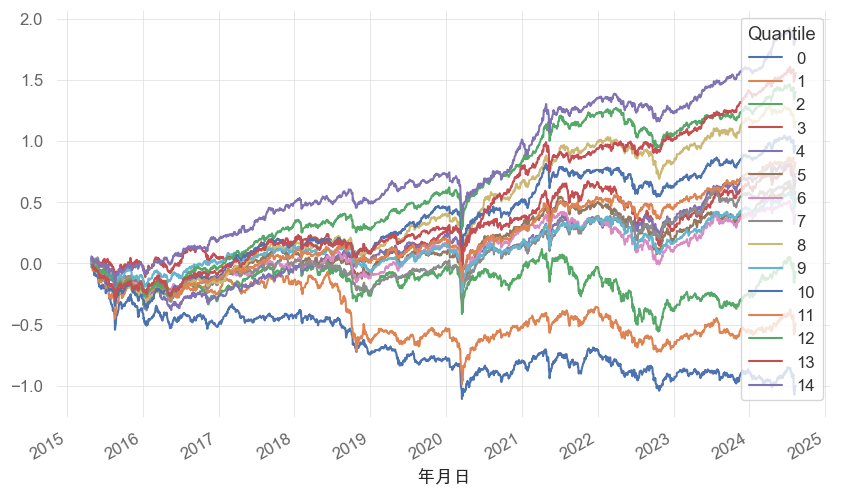

In [41]:
# All sample result
(portfolio).cumsum().plot()

<Axes: xlabel='年月日'>

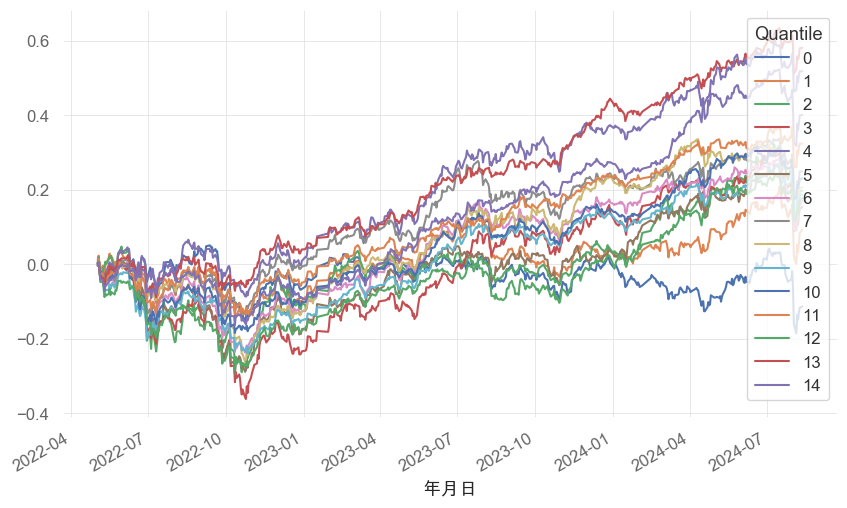

In [42]:
# Out of Sample Result
(portfolio['2022-5-1':]).cumsum().plot()

<Axes: xlabel='年月日'>

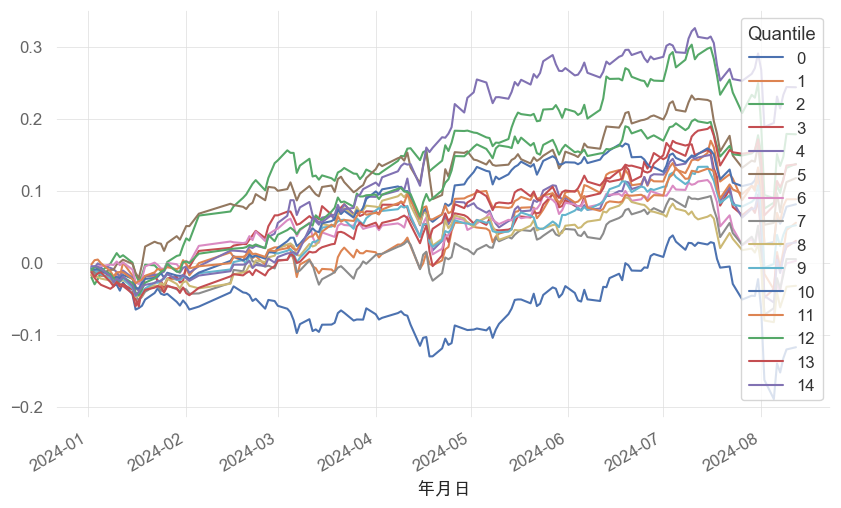

In [43]:
(portfolio['2024-1-1':]).cumsum().plot()

In [45]:
#position[position.index.get_level_values(level=1) == '2330 台積電'].plot()
pos = position[14][position[14] > 0]['2024-8-12']
pos.to_csv('position.csv', encoding='cp950')
pos

證券代碼
2867 三商壽      0.047619
2609 陽明       0.047619
5876 上海商銀     0.047619
4958 臻鼎-KY    0.047619
2888 新光金      0.047619
2809 京城銀      0.047619
9904 寶成       0.047619
2615 萬海       0.047619
2801 彰銀       0.047619
5469 瀚宇博      0.047619
2492 華新科      0.047619
2392 正崴       0.047619
2362 藍天       0.047619
2890 永豐金      0.047619
2357 華碩       0.047619
2201 裕隆       0.047619
2885 元大金      0.047619
2891 中信金      0.047619
2851 中再保      0.047619
2887 台新金      0.047619
2474 可成       0.047619
Name: 14, dtype: float64

<Axes: xlabel='年月日,證券代碼'>

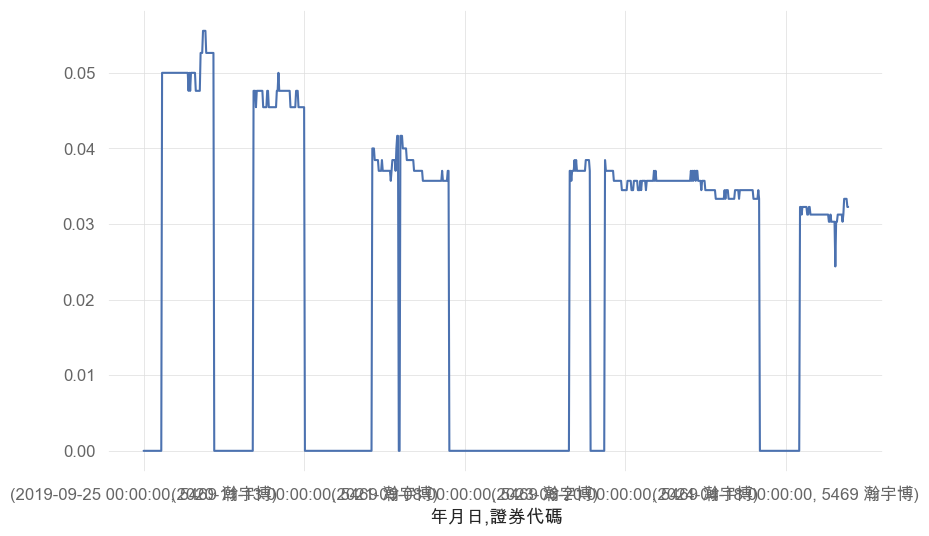

In [36]:
position[9][position.index.get_level_values(level=1) == '5469 瀚宇博'].plot()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


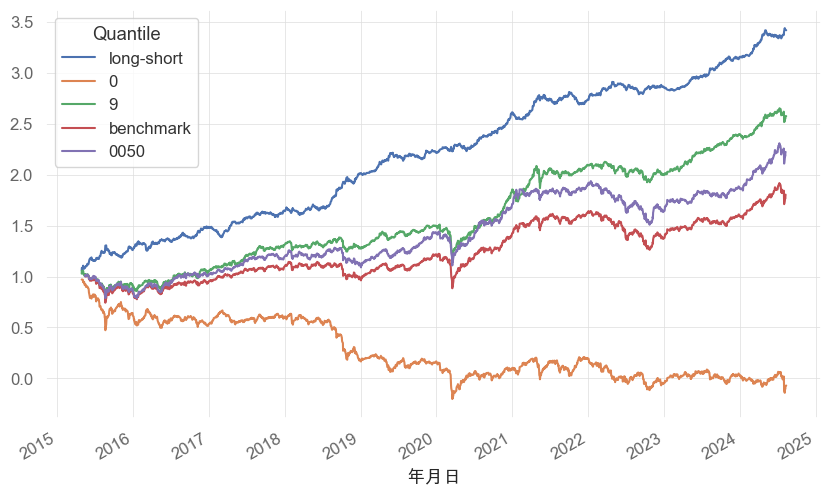

In [222]:
'''
交易成本估算：
    買進： 0.1425%
    賣出： 0.1425%
    證交稅： 0.3%
    每檔進出： 0.585%
    每季共 20*3 = 60 個交易日，平均每日交易成本 約 0.01%
'''
plot_portfolio(portfolio, tc = 0.0001, compounded = False)

In [229]:
metrics = qs.reports.metrics(portfolio[[0, 9, 'long-short', '0050', 'benchmark']], mode = 'Full', compounded=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a s

                           0           9           long-short    0050        benchmark
-------------------------  ----------  ----------  ------------  ----------  -----------
Start Period               2015-05-15  2015-05-15  2015-05-15    2015-05-15  2015-05-15
End Period                 2024-08-09  2024-08-09  2024-08-09    2024-08-09  2024-08-09
Risk-Free Rate             0.0%        0.0%        0.0%          0.0%        0.0%
Time in Market             100.0%      100.0%      100.0%        97.0%       100.0%

Cumulative Return          -67.9%      322.04%     852.05%       197.06%     98.41%
CAGR﹪                     -8.14%      11.35%      18.33%        8.47%       5.25%

Sharpe                     -0.6        1.09        2.23          0.77        0.55
Prob. Sharpe Ratio         3.28%       99.91%      100.0%        98.85%      94.83%
Smart Sharpe               -0.56       1.02        2.07          0.71        0.51
Sortino                    -0.76       1.48        3.64          1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To 

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2015-05-15   2015-05-15
End Period                 2024-08-12   2024-08-12
Risk-Free Rate             0.0%         0.0%
Time in Market             96.0%        100.0%

Cumulative Return          193.1%       864.12%
CAGR﹪                     8.36%        18.42%

Sharpe                     0.76         2.24
Prob. Sharpe Ratio         98.77%       100.0%
Smart Sharpe               0.72         2.11
Sortino                    1.08         3.65
Smart Sortino              1.02         3.44
Sortino/√2                 0.77         2.58
Smart Sortino/√2           0.72         2.43
Omega                      1.45         1.45

Max Drawdown               -36.04%      -11.66%
Longest DD Days            774          372
Volatility (ann.)          17.95%       11.6%
R^2                        0.01         0.01
Information Ratio          0.04         0.04
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-04-28,2022-09-02,2023-05-04,372,-11.657065,-10.943253
2,2021-10-04,2021-11-19,2022-03-03,151,-11.608695,-11.443591
3,2015-08-26,2015-11-05,2016-01-11,139,-11.475871,-11.277334
4,2016-12-21,2017-03-02,2017-04-11,112,-10.160220,-9.625596
5,2016-01-27,2016-03-07,2016-05-09,104,-8.696698,-8.506342


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


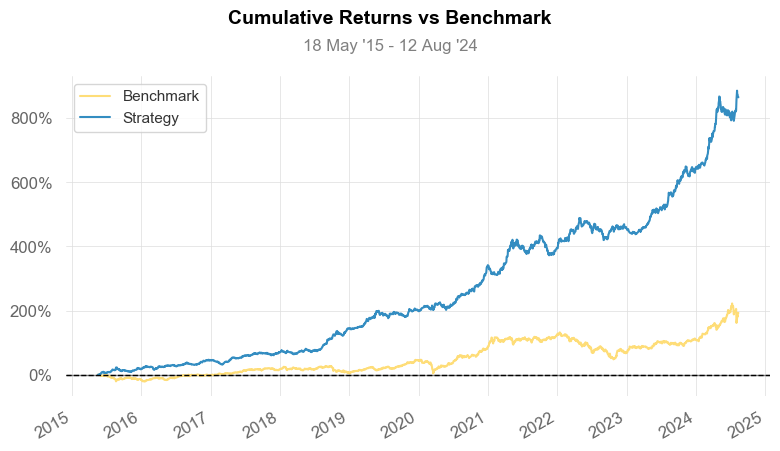

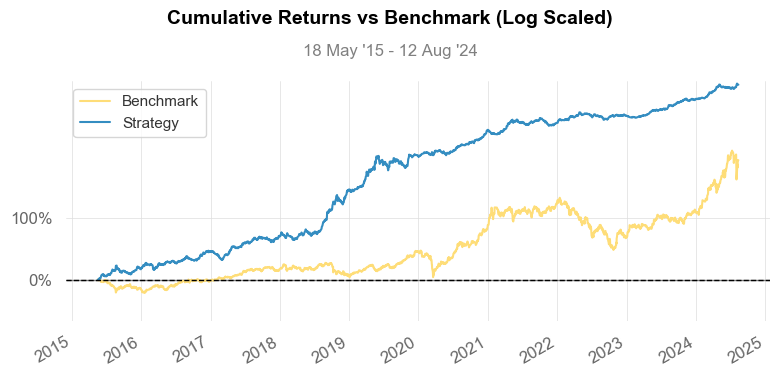

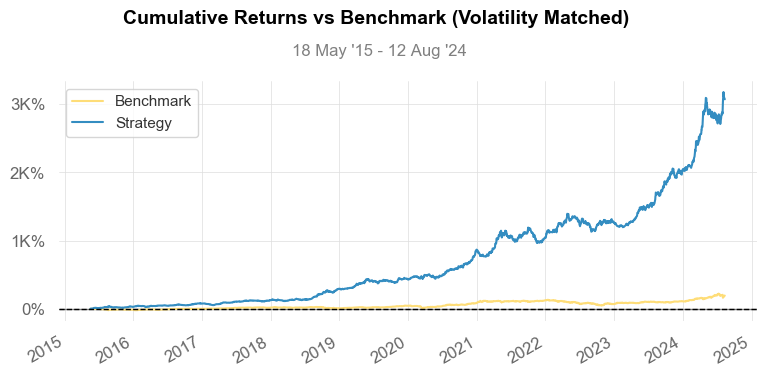

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:555: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:557: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


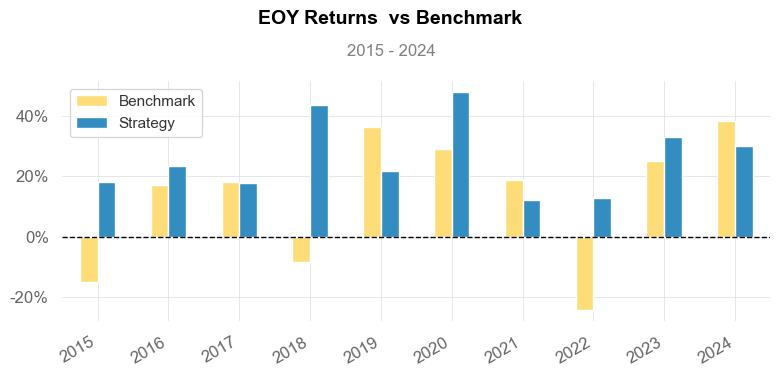

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:433: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:435: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

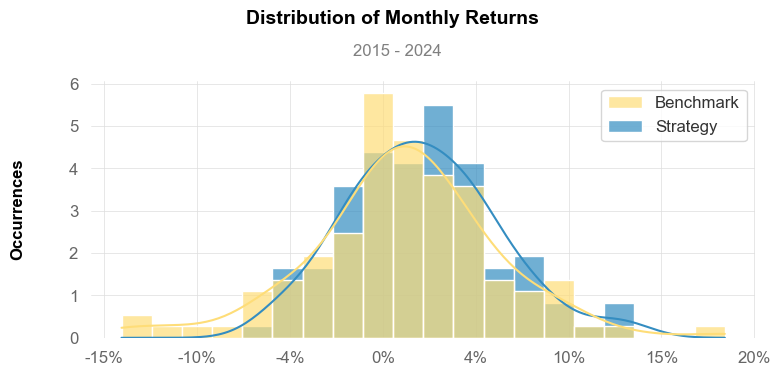

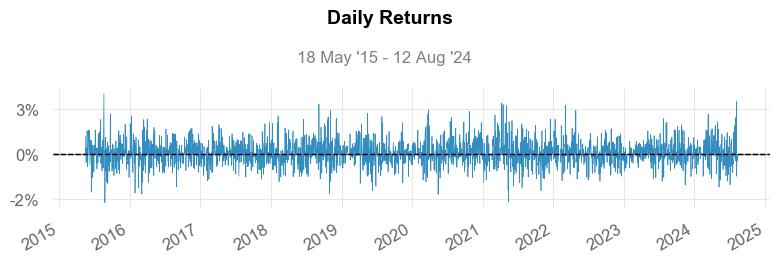

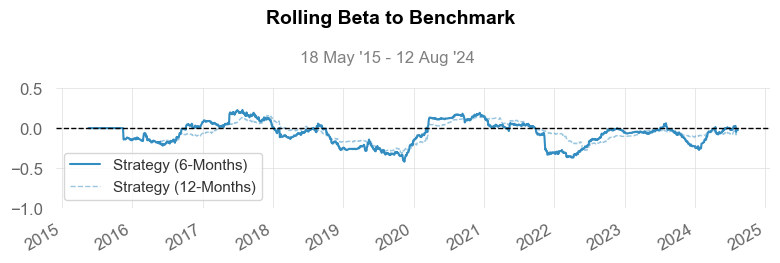

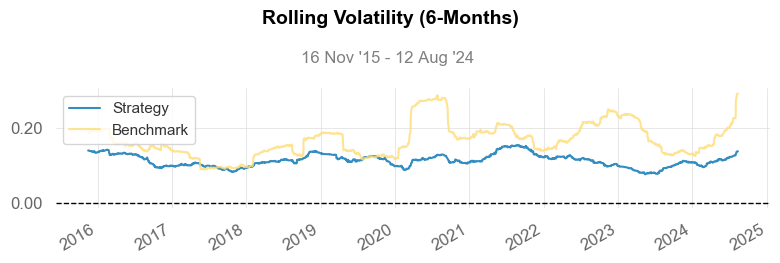

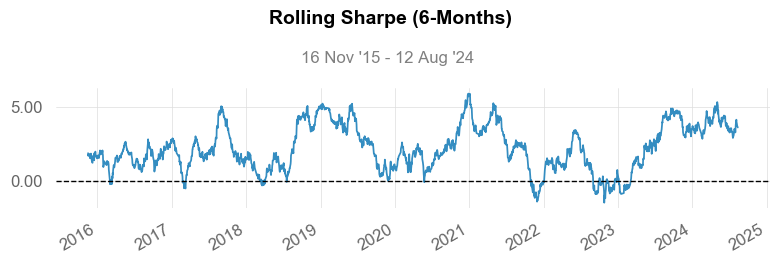

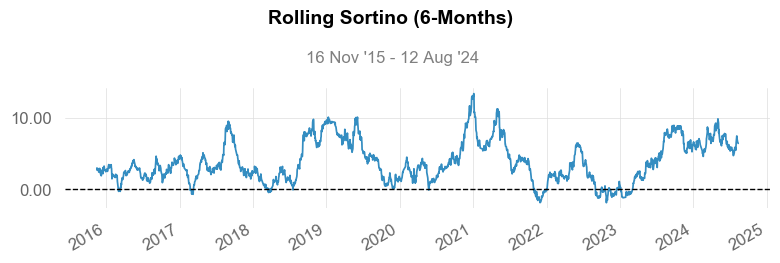

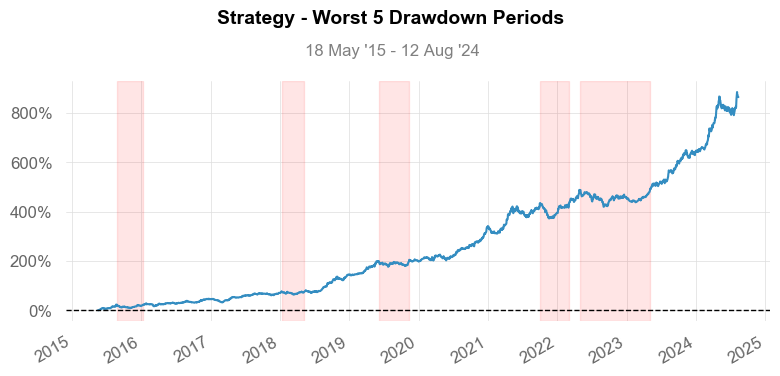

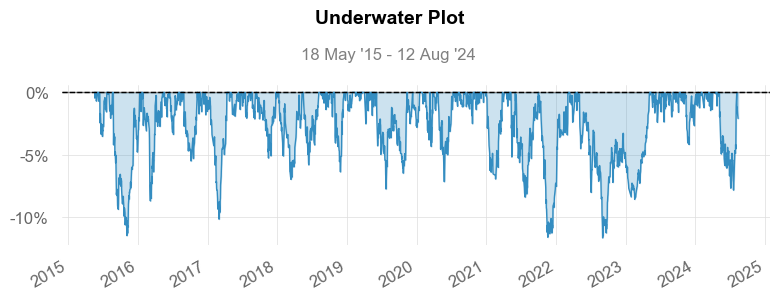

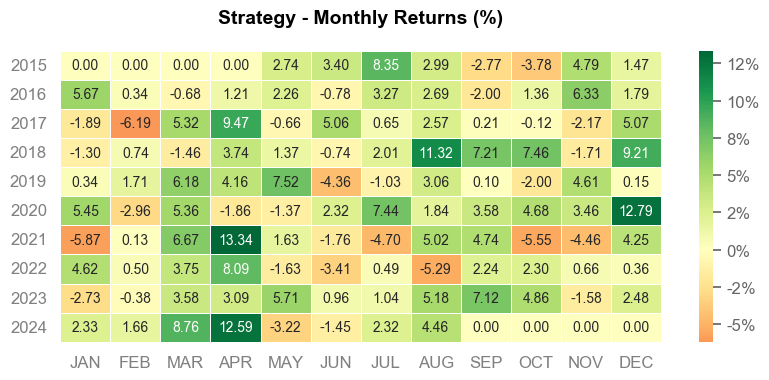

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
/Library/Frameworks/Python.framework/Versions/3.10/lib/py

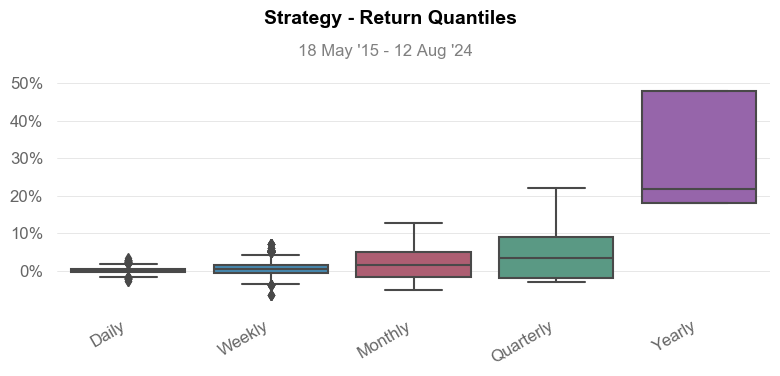

In [230]:
qs.reports.full(portfolio.loc[:, 'long-short'], benchmark=portfolio['0050'], active_returns = False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To 

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2015-05-15   2015-05-15
End Period                 2024-08-12   2024-08-12
Risk-Free Rate             0.0%         0.0%
Time in Market             96.0%        100.0%

Cumulative Return          193.1%       327.58%
CAGR﹪                     8.36%        11.45%

Sharpe                     0.76         1.1
Prob. Sharpe Ratio         98.77%       99.92%
Smart Sharpe               0.75         1.09
Sortino                    1.08         1.49
Smart Sortino              1.07         1.48
Sortino/√2                 0.77         1.05
Smart Sortino/√2           0.76         1.05
Omega                      1.22         1.22

Max Drawdown               -36.04%      -31.25%
Longest DD Days            774          477
Volatility (ann.)          17.95%       15.9%
R^2                        0.5          0.5
Information Ratio          0.02         0.02
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-20,2020-03-18,2020-08-12,206,-31.247757,-27.220788
2,2015-05-19,2015-08-21,2016-09-06,477,-21.722196,-16.788768
3,2021-04-28,2021-05-14,2022-01-11,259,-20.068729,-14.764799
4,2022-03-24,2022-10-25,2023-05-04,407,-19.000808,-18.153143
5,2018-09-21,2018-10-26,2019-03-29,190,-13.191998,-13.113014


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


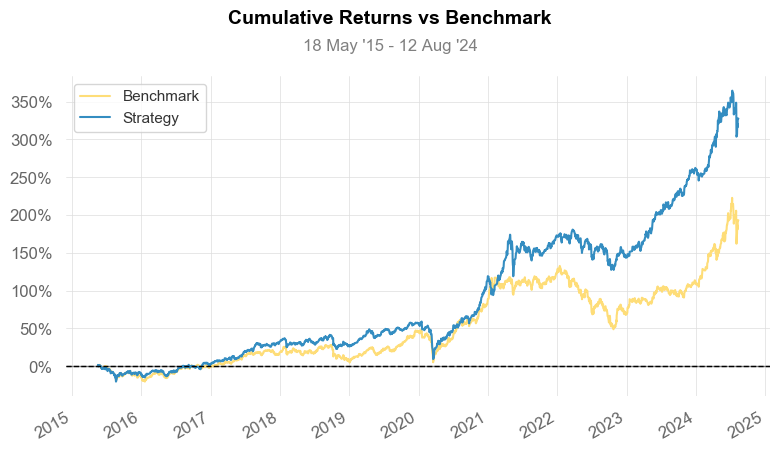

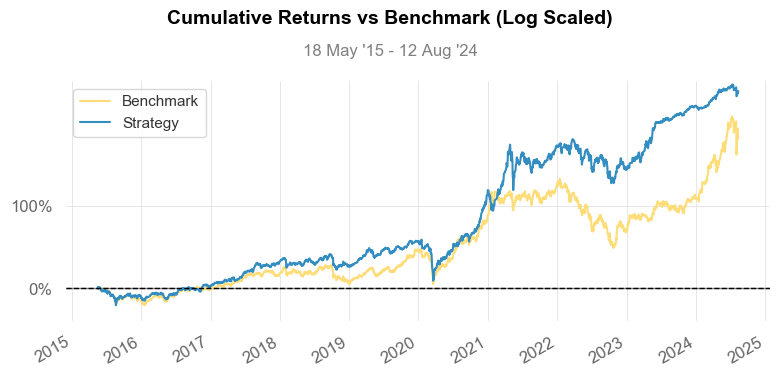

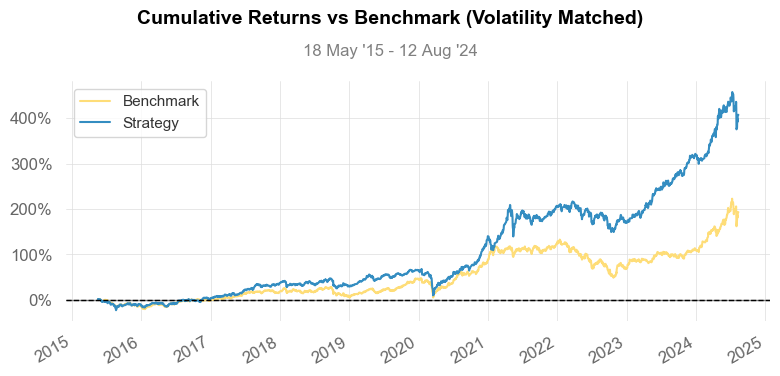

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:555: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:557: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


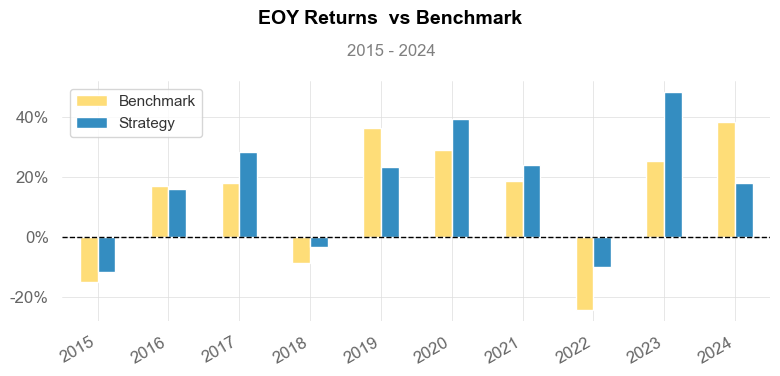

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:433: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:435: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

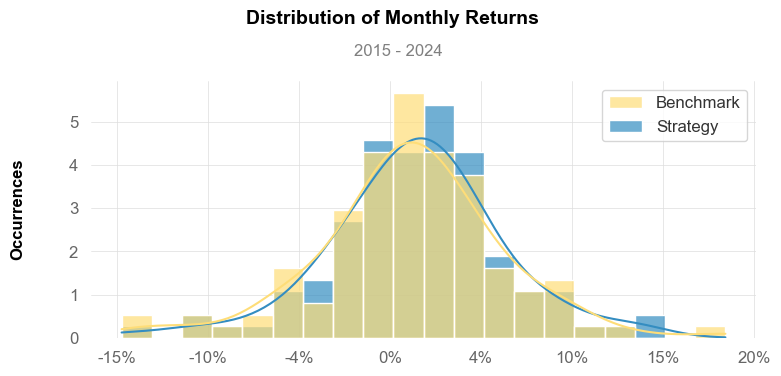

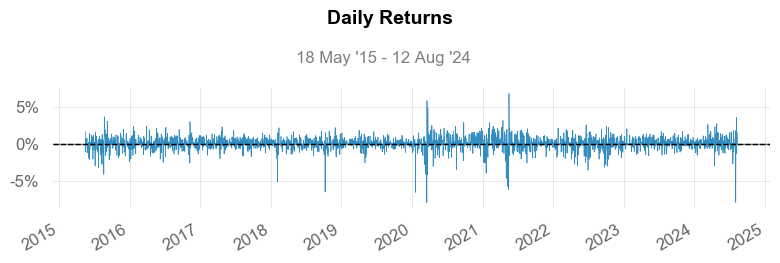

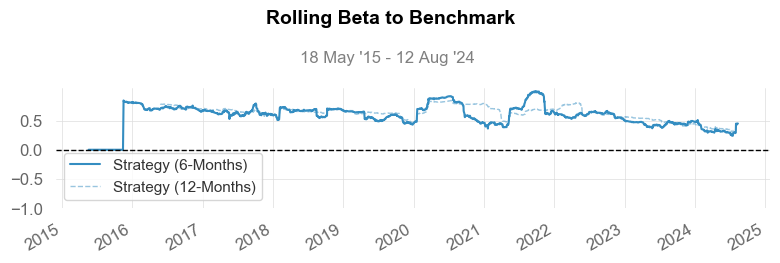

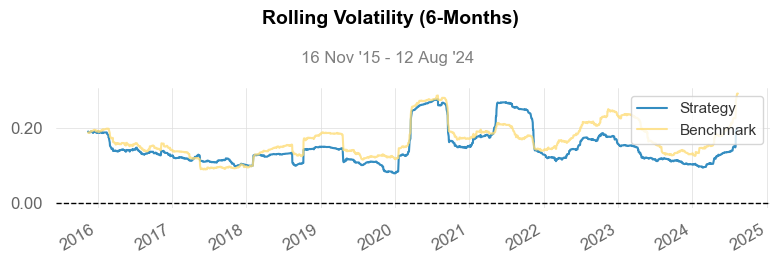

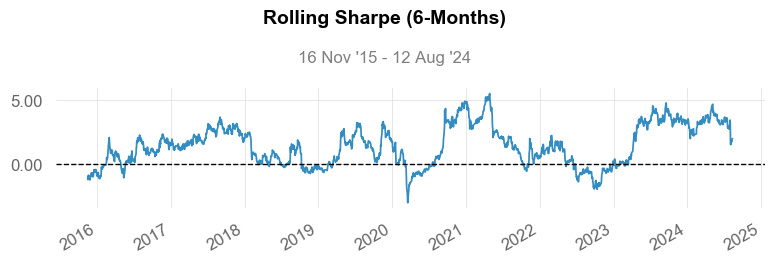

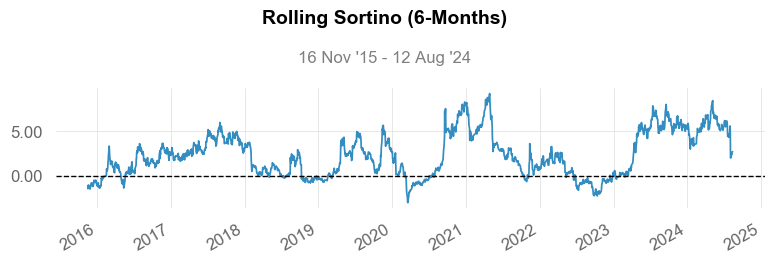

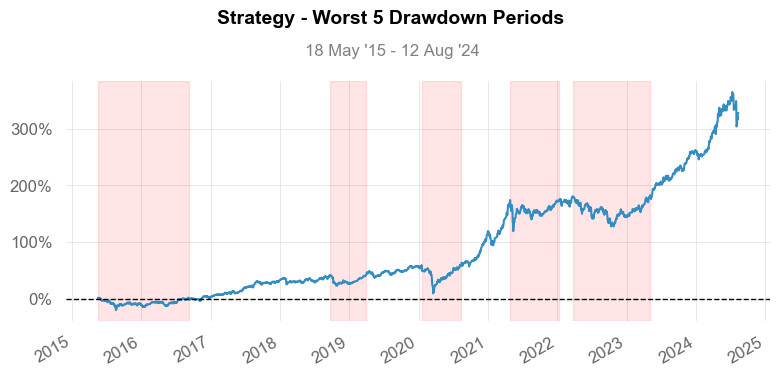

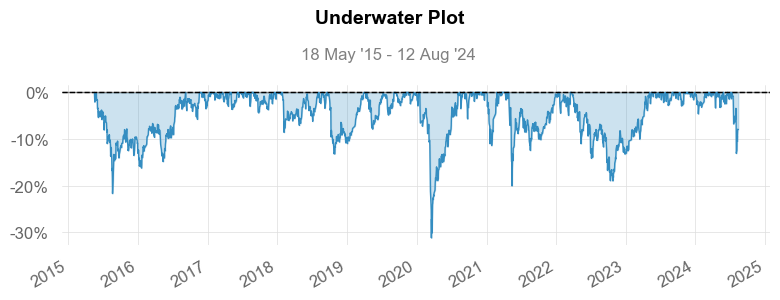

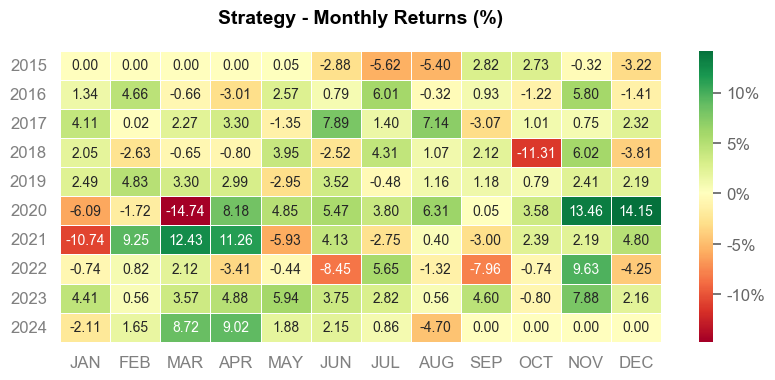

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
/Library/Frameworks/Python.framework/Versions/3.10/lib/py

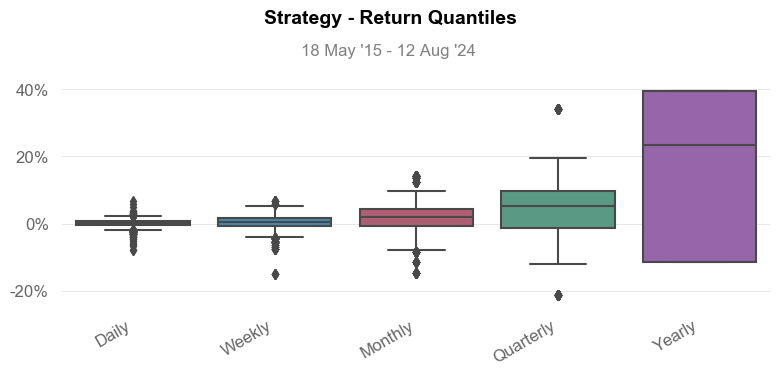

In [232]:
qs.reports.full(portfolio.loc[:, 9], benchmark=portfolio['0050'], active_returns = False)

In [177]:
qs.reports.html(portfolio['long-short'], benchmark=portfolio['0050'], active_returns = False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To 